In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
from zipfile import ZipFile
from urllib.request import urlretrieve

In [4]:
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)

In [5]:
ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/',1)[1]
ML_100K_FOLDER = 'ml-100k'

In [6]:
if not os.path.exists(ML_100K_FILENAME):
    logging.info(f'downloading {ML_100K_URL}...')
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

In [7]:
if not os.path.exists(ML_100K_FOLDER):
    logging.info(f'extracting {ML_100K_FILENAME} to {ML_100K_FOLDER}')
    ZipFile(ML_100K_FILENAME).extractall('.')

In [8]:
import pandas as pd

In [9]:
raw_ratings = pd.read_csv(
    os.path.join(ML_100K_FOLDER, 'u.data'), 
    sep='\t', 
    names=['user_id','item_id', 'rating', 'timestamp']
)

raw_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [10]:
items = pd.read_csv(
    os.path.join(ML_100K_FOLDER, 'u.item'),
    sep='|',
    names=['item_id', 'title', 'release_date','video_release_date', 'imdb_url'],
    usecols=range(5),
    encoding='latin-1'
)
items.head()

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ff13e80>]],
      dtype=object)

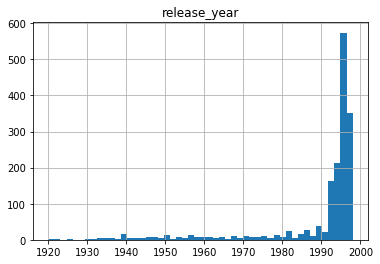

In [11]:
def extract_year(release_date):
    if hasattr(release_date, 'split'):
        components = release_date.split('-')
        if len(components)==3:
            return int(components[2])
    return 1920

items['release_year'] = items['release_date'].map(extract_year)
items.hist('release_year', bins=50)

In [12]:
all_ratings = pd.merge(items,raw_ratings)
all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


# data preprocessing

In [13]:
max_user_id = all_ratings['user_id'].max()
max_user_id

943

In [14]:
max_item_id = all_ratings['item_id'].max()
max_item_id

1682

In [15]:
all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [16]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items)
items.nlargest(10, 'popularity')

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year
49,50,583,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977
257,258,509,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),1997
99,100,508,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),1997
180,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997
293,294,485,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),1997
285,286,481,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,1996
287,288,478,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),1996
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
299,300,431,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,1997
120,121,429,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,1996


In [17]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings.head()


,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


In [18]:
from sklearn.model_selection import train_test_split

In [19]:
ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0
)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['rating']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['rating']

# explicit feedback: supervised ratings prediction

## predictive ratings as regression problem

In [20]:
#from tensorflow.contrib import keras
from keras.layers import Input, Embedding, Flatten, Dense, Dropout
from keras.layers import Dot
from keras.models import Model
from keras import models
from keras import layers

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

In [22]:
embedding_size = 30
user_embedding = Embedding(
    output_dim=embedding_size, 
    input_dim = max_user_id + 1,
    input_length = 1,
    name = 'user_embedding'
)(user_id_input)
item_embedding = Embedding(
    output_dim = embedding_size,
    input_dim = max_item_id + 1,
    input_length = 1,
    name = 'item_embedding'
)(item_id_input)

In [23]:
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

In [24]:
y = Dot(axes=1)([user_vecs, item_vecs])

In [25]:
model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='mae')

In [26]:
initial_train_preds = model.predict([user_id_train, item_id_train])
initial_train_preds.shape

(80000, 1)

In [35]:
rating_vec =rating_train.values.reshape(-1,1)

In [37]:
err=rating_vec - initial_train_preds
abs_err=np.abs(err)
mae = np.mean(err)
mae

3.528547859406891

In [38]:
sq_err = np.square(err)
mse = np.mean(sq_err)
mse

13.71940406088571

In [40]:
%%time

history = model.fit(
    x=[user_id_train, item_id_train], 
    y=rating_train,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    epochs=6
)

Train on 72000 samples, validate on 8000 samples
Epoch 1/6
72000/72000 [==============================] - 2s 28us/step - loss: 0.9764 - val_loss: 0.8420
Epoch 2/6
72000/72000 [==============================] - 2s 27us/step - loss: 0.7792 - val_loss: 0.7829
Epoch 3/6
72000/72000 [==============================] - 2s 30us/step - loss: 0.7423 - val_loss: 0.7661
Epoch 4/6
72000/72000 [==============================] - 2s 28us/step - loss: 0.7261 - val_loss: 0.7568
Epoch 5/6
72000/72000 [==============================] - 2s 28us/step - loss: 0.7133 - val_loss: 0.7507
Epoch 6/6
72000/72000 [==============================] - 2s 28us/step - loss: 0.7028 - val_loss: 0.7501
CPU times: user 20.6 s, sys: 4.54 s, total: 25.1 s
Wall time: 12.2 s


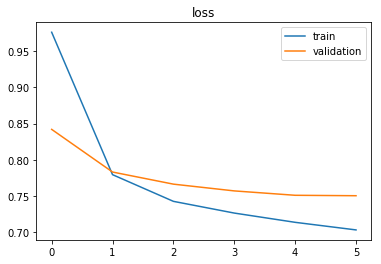

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
#plt.ylim(0,2)
plt.legend(loc='best')
plt.title('loss')

In [44]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [45]:
test_preds = model.predict([user_id_test, item_id_test])
mae = mean_absolute_error(test_preds, rating_test)
mse = mean_squared_error(test_preds, rating_test)
print(f'final test MAE: {mae}')
print(f'final test MSE: {mse}')

final test MAE: 0.7415607536148745
final test MSE: 0.9322659154295885


In [46]:
train_preds = model.predict([user_id_train, item_id_train])
mae = mean_absolute_error(train_preds, rating_train)
mse = mean_squared_error(train_preds, rating_train)
print(f'final train MAE: {mae}')
print(f'final train MSE: {mse}')

final train MAE: 0.6845496830917255
final train MSE: 0.8174235684853539


In [47]:
from keras.layers import Concatenate